In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt
import scipy as sp
import cmath
import time 
import math

%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)


In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data



def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    if(center!=None):
        centerX,centerY=center
    else:
        centerX=XPixel/2
        centerY=YPixel/2

    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<radius
    values=np.zeros(rr.shape)
    values[mask]=1
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]
    

    

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1).optimize
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay=None):
    x,y=xy
    if(sigmay==None):
        sigmay=sigmax
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value



def RadialAverage(pws,radius,Amou,center=None):
    xp=np.arange(pws.shape[0])
    yp=np.arange(pws.shape[0])
    xx,yy=np.meshgrid(xp,yp)
    pws=np.fft.fftshift(pws)
    if not center:
        center=[pws.shape[0]/2,pws.shape[0]/2]
    R=np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    
    radial = lambda r:pws[(R>=r-0.5) & (R<r+0.5)].mean()
    r=np.arange(1,radius,1)
    PWS1D=np.vectorize(radial)(r)
    return PWS1D

def my_ceil(a, precision=0):
    return np.truellowing the steps above to upl_divide(np.ceil(a * 10**precision), 10**precision)

def my_floor(a, precision=0):
    return np.true_divide(np.floor(a * 10**precision), 10**precision)



In [3]:
## Average the images
def AvergImage(Images,rangex,Single=True,start=0):
    img=np.zeros(Images[0].shape)
    if (rangex>len(Images.keys())):
        rangex=len(Images.keys())
    # Average only one set
    if(Single):
        for i in range(st
art,rangex+start):
            img+=Images[i]
        img=img/rangex
        return img
    else: # Average Multiple Sets of Images
        cnt=0
        fImages=[]
        while(cnt<=len(Images.keys())-1):
            img+=Images[cnt]
            if (cnt%(rangex)==0 and cnt>0):
                fImages.append(img/rangex)
                img=np.zeros(Images[0].shape)
            cnt=cnt+1
        return fImages
import cv2

### Obtained from  https://gist.github.com/i-namekawa/74a817683b0e68cee521
def paddedzoom(img, zoomfactor=0.8):
    
    '''
    Zoom in/out an image while keeping the input image shape.
    i.e., zero pad when factor<1, clip out when factor>1.
    there is another version below (paddedzoom2)
    '''

    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx=zoomfactor, fy=zoomfactor)
    
    h, w = img.shape
    zh, zw = zoomed.shape
    
    if zoomfactor<1:    # zero padded
        out[round((h-zh)/2):-round((h-zh)/2), round((w-zw)/2):-round((w-zw)/2)] = zoomed
    else:               # clip out
        out = zoomed[(zh-h)/2:-(zh-h)/2, (zw-w)/2:-(zw-w)/2]

    return out
## Zooms out    
def paddedzoom2(img, zoomfactor=0.8):
    
    h,w = img.shape
    M = cv2.getRotationMatrix2D( (w/2,h/2), 0, zoomfactor) 
    
    return cv2.warpAffine(img, M, img.shape[::-1])

def Smearing(img,sigma=None,kernel=None):
    import scipy.ndimage as ndimage
    if(kernel):
        # Create a Gaussian kernel
        kernel = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]]) / 16
        smeared_image = ndimage.gaussian_filter(img, kernel=kernel)

    else:
        # Smear the image
        smeared_image = ndimage.gaussian_filter(img, sigma=sigma)
    return smeared_image
    

In [4]:
#theImage=AvergImage(Images,100,Single=True)
Alphas=Alphas=PickleITRead("../3NeedleDiff.p")

In [5]:
from PIL import Image

factor=1
iig=Image.open("../mesh.png").convert('L') ### Load image and Convert to Gray Scale
iig=iig.resize((factor*512,factor*512))
iig=np.array(np.invert(iig)) ## invert Collors
iig=iig/np.max(iig) ## Normalize


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


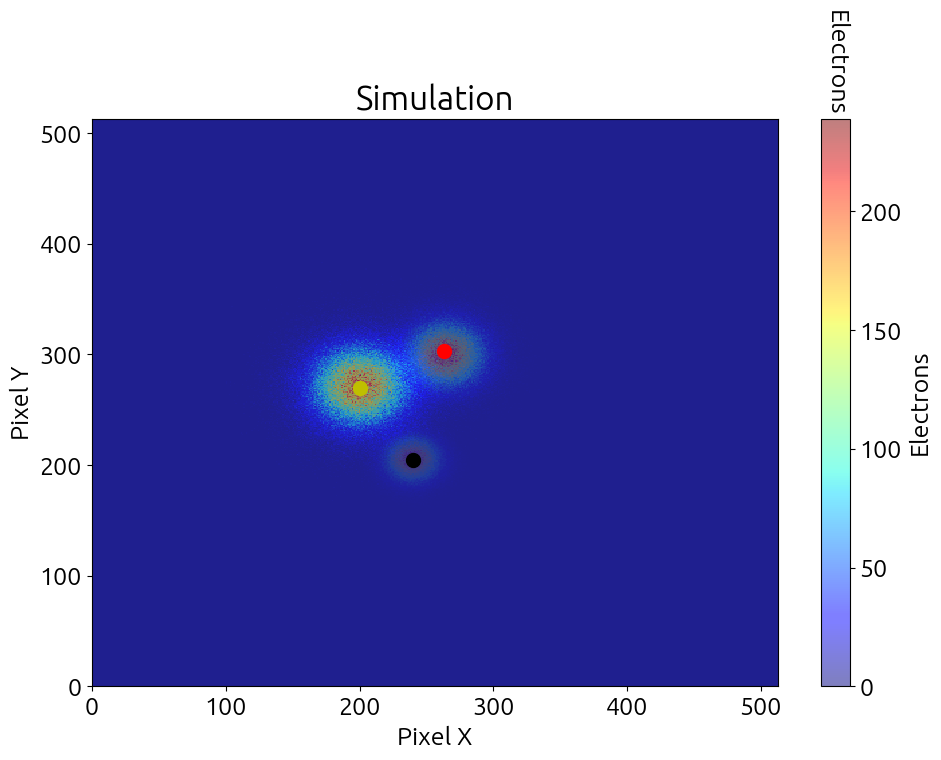

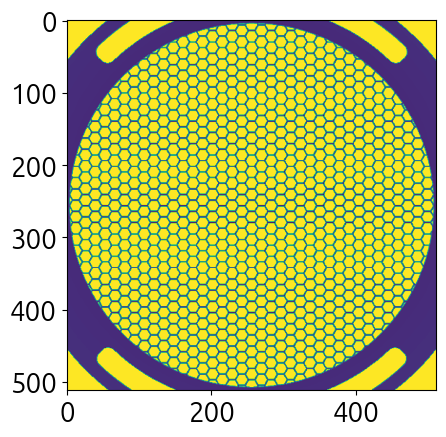

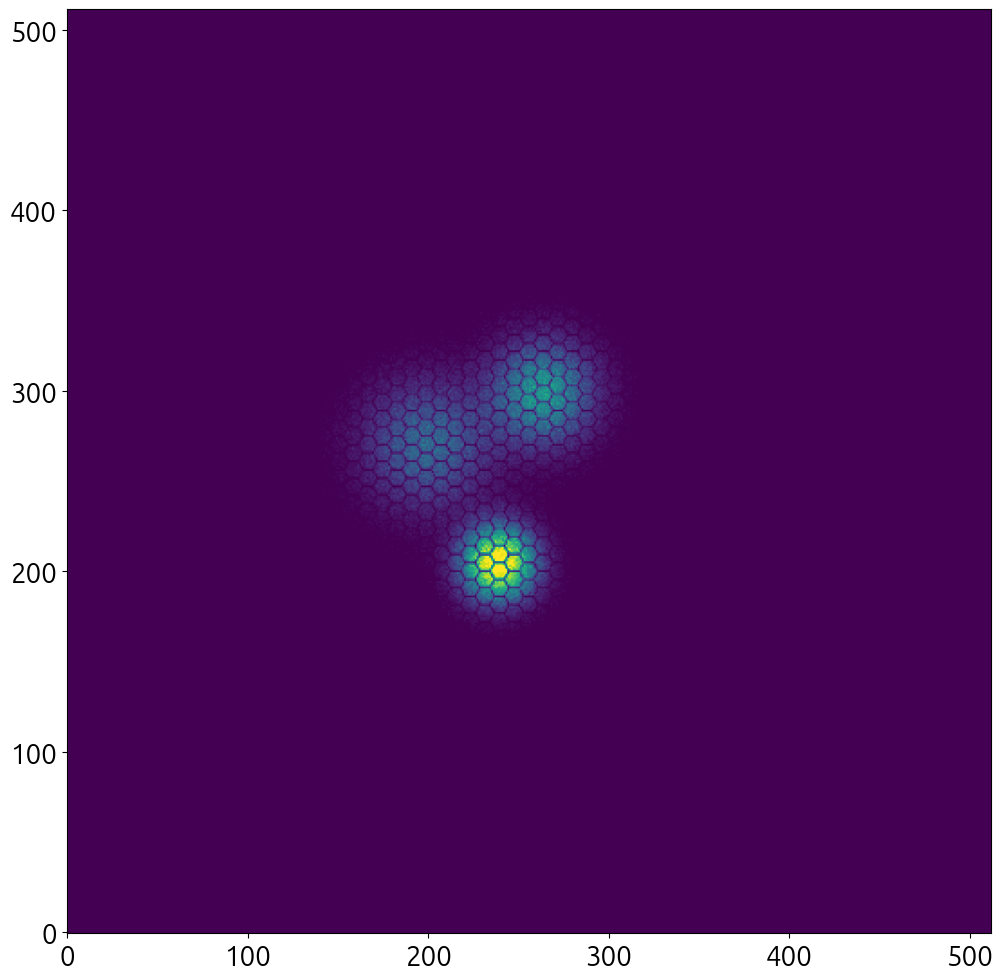

In [58]:
    
pixelSize=16e-3 #mm
Magnefication=10

size=513
bins = [np.linspace(0, size,size), np.linspace(0, size,size)]
cmap = plt.get_cmap('cividis')
cmap = plt.get_cmap('jet')

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(111)
title=f"Simulation"
ax1.set_title(title)
if(Magnefication>10):
    Shift=[92,92]
else:
    Shift=[0,0]
off=[0,20]
PixelX=(Alphas["Alpha1"][0]/(pixelSize*Magnefication)-10+Shift[0])+off[0]
PixelY=(Alphas["Alpha1"][1]/(pixelSize*Magnefication)-63+Shift[1])+off[1]

h1 = ax1.hist2d(PixelX, PixelY, bins=bins, cmap=cmap,alpha=0.5)
print(h1[0])

PixelX=(Alphas["Alpha2"][0]/(pixelSize*Magnefication)+15+Shift[0])
PixelY=(Alphas["Alpha2"][1]/(pixelSize*Magnefication)+55+Shift[1])    
h2 = ax1.hist2d(PixelX, P
ixelY, bins=bins, cmap=cmap,alpha=0.5)

PixelX=(Alphas["Alpha3"][0]/(pixelSize*Magnefication)-43+Shift[0])
PixelY=(Alphas["Alpha3"][1]/(pixelSize*Magnefication)+22+Shift[1])
h3 = ax1.hist2d(PixelX, PixelY, bins=bins, cmap=cmap,alpha=0.5)


CenterPoint=(200,270)
plt.scatter(*CenterPoint,s=100,color="y",marker="o") ##  15cm


CenterPoint=(263,303)
#Needle10cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
plt.scatter(*CenterPoint,s=100,color="r",marker="o") ##  10cm


CenterPoint=(240,185)

#Needle5cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
CenterPoint=(240+off[0],185+off[1])
plt.scatter(*CenterPoint,s=100,color="k",marker="o") ##  5cm
cbar1 = plt.colorbar(h1[3])
cbar1.set_label('Electrons', fontsize=18)
cbar1.ax.tick_params(labelsize=18)
cbar1.ax.set_title('Electrons',fontsize=18, rotation=270)

ax1.set_ylabel(r'Pixel Y',fontsize=18)
ax1.set_xlabel(r'Pixel X',fontsize=18)
ax1.tick_params(labelsize=18)
ax1.set_xlim(0,size)
ax1.set_ylim(0,size)

plt.tight_layout()
# plt.savefig("Reco_Hist.png",dpi=250,bbox_inches='tight')
plt.show()

plt.imshow(iig )
plt.figure(figsize=(12,12))
Mesh=MaskCreate((512,512),250,center=None)[1]*iig 
ZoomIn=paddedzoom2(Mesh,0.6)
image=np.transpose(np.zeros((512,512))+h1[0]+h2[0]+h3[0])*ZoomIn
#image=Smearing(image,sigma=1.5)
plt.imshow(image,origin="lower",vmin=np.mean(image),vmax=0.8*np.max(image))

          
Needle1=MaskCreate(h1[0].shape,50,(200,270))[1]*image
Needle2=MaskCreate(h2[0].shape,50,(263,303))[1]*image
Needle3=MaskCreate(h3[0].shape,10,(240,185))[1]*image




In [7]:
Error = lambda Observed,Expected:abs(Observed-Expected)/Expected
def WAverage(img):
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)

    PixelX=xx.ravel()
    PixelY=yy.ravel()
    
    
    weights1d=img.ravel()
    Mult1dX=np.sum(weights1d*PixelX)
    Sumweight1dX=np.sum(weights1d)
    ax=Mult1dX/Sumweight1dX
    
    
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dX=np.sum(weights1d)
    Mult1dY=np.sum(weights1d*PixelY)
    Sumweight1dY=np.sum(weights1d)
    ay=Mult1dY/Sumweight1dY
    

    return ax,ay
#x = np.linspace(0, theImage.shape[0], theImage.shape[0])
#y=  np.linspace(0, theImage.shape[1], theImage.shape[1])
#xx, yy = np.meshgrid(x, y)
#WeightedPixelX=np.average(xx,weights=theImage)
#WeightedPixelY=np.average(yy,weights=theImage)



In [8]:
def WeightedAverage(img,mask,Radius,f):
    ## Method 2 Weighted Average Estimation
    isPrint=f["isPrint"]
    
    x = np.linspace(0, img.shape[0], img.shape[0])
    y=  np.linspace(0, img.shape[1], img.shape[1])
    xx, yy = np.meshgrid(x, y)
    
    rr=np.sqrt(xx**2+yy**2)
    
    # Estimate the Max Intensity
    mAx=np.max(img[mask[0]])
    MaxMask2D=mAx==img*mask[0]
    MaxMask1D=mAx==img[mask[0]]
    
    # Estimate the Max Intensity in a given region
    Cmax=(np.where(MaxMask2D)[1],np.where(MaxMask2D)[0])
    
    if(isPrint):
        print(f"Max is {img[Cmax]} at {Cmax}")
    
    ## Create a Mask that is Centered in Maximum Intensity
    if(len(Cmax[0])>1 or len(Cmax[1])>1):
        print(f"CenterX is {Cmax[0]} and CenterY is {Cmax[1]}")
    cc=MaskCreate(img.shape,Radius,(Cmax[0],Cmax[1]),False)
    
    ## Estimate the Mean
    #Mean=np.average(img[cc[0]],weights=rr[cc[0]])
    
        ## Find the Pixel that is closest to mean
    #ErrorV=Error(img[cc[0]],Mean)
    #MinLoc=np.where(ErrorV==np.min(ErrorV))
    #PixelLoc=np.where(img*cc[0]==img[cc[0]][MinLoc])
    #print(PixelLoc)
   
    WeightedPixelX=np.average(xx[cc[0]],weights=img[cc[0]])
    WeightedPixelY=np.average(yy[cc[0]],weights=img[cc[0]])
    
    PixelX=xx[cc[0]]
    PixelY=yy[cc[0]]
    weightsA=img[cc[0]]
    
    np.average(PixelX*PixelY,weights=weightsA)
    if(isPrint):
        print(f"Weighted Average {(WeightedPixelX,WeightedPixelY)} ")
    return [[WeightedPixelX,WeightedPixelY],[Cmax[0][0],Cmax[1][0]]]
    

In [9]:

#theImage,Radius,NumberOfRings,PixelAmount,centerPoint
def RadialAverageRings(FitV):
    values=FitV["Img"]
    ## Create an array containing with pixel size of the image
    x=np.arange(0,FitV["Img"].shape[0],1)
    
    #Create a coordinate matrix from the pixel size
    xx,yy=np.meshgrid(x,x)
    ## if there is no center point defined then set it at (0,0)
    if FitV["Center"]:
        centerX,centerY=FitV["Center"]
    else:
        centerX,centerY=(0,0)
    R=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    Rings=np.linspace(0,FitV["Radius"],FitV["NumberOfCircles"])
    radialMean = lambda r:(values[(R>=r) & (R<(r+FitV["PixelIncrement"]))]).mean()
    vv=np.array([])
    for i in Rings:
        vv=np.append(vv,radialMean(i))
    return vv,Rings

In [10]:

def Lorentzian(x,a,x0,gamma,offset):
    denominator=np.pi*gamma*(1+((x-x0)/gamma)**2)
    result=((a*1)/(denominator))+offset
    return result

def Gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def Voigt_Fit(x,a,x0,gamma,sigma,offset):
   ## Lorentzian
    if (sigma==0 and gamma>0):
        return Lorentzian(x,a,x0,gamma,offset)
    ## Gaussian
    #elif (gamma==0 and sigma>0):
        #return Gauss(x, a, x0, sigma)
    top=np.vectorize(complex)((x-x0),gamma)
    z=top/(sigma*np.sqrt(2))
    wz=sp.special.wofz(z)
    denom=sigma*np.sqrt(2*np.pi)
    result=a*(np.real(wz)/denom)+offset
    return result

def Rsquared(ydata,f):
    mean=np.mean(ydata)
    SStot=np.sum((ydata-mean)**2)
    SSres=np.sum((ydata-f)**2)
    Rsqr=1-SSres/SStot
    return Rsqr


In [11]:


def PeakFinder(data,FitV):
    xlow=FitV["PeakRegion"][0]
    xhigh=FitV["PeakRegion"][1]
    step=FitV["PeakStep"]
    polarity=FitV["polarity"]
    isPrint=FitV["isPrint"]

    if(isPrint):
        print("Running Peak Finder Algorithm ..")
    ## First Get the lenth of the time
    Length=len(data[0])
    YProfile=np.array([])
    XProfile=np.array([])
    
    
    ## Obtain the max and min pixel
    if(not xlow and not xhigh):
        MinPixel=np.min(data[0])
        MaxPixel=np.max(data[0])
    else:
        MinPixel=xlow
        MaxPixel=xhigh
    
    #Start Time
    TempPixel=MinPixel
    if(isPrint):
        print(f"Max time is {MaxPixel}")
        print(f"Min time is {MinPixel}")
        print(f"Event Length is {Length}")

    for i in range(0, Length):
        if(TempPixel>=MaxPixel):
            if(isPrint):
                print("Ma
x Pixel is reached")
            break
            
        PixelMask=(data[0]>=TempPixel) & (data[0]<=TempPixel+step ) 
        
        ## Check if there is any peak here
        if(np.sum(PixelMask)==0):
            TempPixel=TempPixel+step
            continue
         
        ## Obtain the minum
        if(polarity=="pos"):
            Max=np.max(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Max
        else:
            Min=np.min(data[1][PixelMask])
            AmpMask=data[1][PixelMask]==Min

        ## Only Negative Pulse        
        XProfile=np.append(XProfile,data[0][PixelMask][AmpMask])
        YProfile=np.append(YProfile,data[1][PixelMask][AmpMask])

        TempPixel=TempPixel+step 
    if(isPrint):
        print(f"Number of Peaks is {len(XProfile)}")
    return XProfile,YProfile
    
#Radius,AmountOfRings,GapDistance
def Obtain1DFit(FitV):
    ## Radius, Precision, 
    ## Obtain Gaussian by getting radial average 
    vvv=RadialAverageRings(FitV)
    
    ### Since this is symmetric in X axis flip the  data
    datax=-1*np.flip(vvv[1])
    datay=np.flip(vvv[0])
    datax=np.append(datax,vvv[1])
    datay=np.append(datay,vvv[0])

    #Normalize and Remove the DC offset
    datay=datay/np.max(datay)
    datay=datay-np.mean(datay[(datax>FitV["DCRegion"][0]) & (datax<=FitV["DCRegion"][1])])
    pks=PeakFinder([datax,datay],FitV)
    ## Plot the data vs fit
    if(FitV["isPlot"][0]):
        plt.figure(figsize=(8,8),dpi=200)
        plt.plot(datax,datay,'-o',label=FitV["labelx"])
    
    x=np.linspace(np.min(datax),np.max(datax),len(datax))
    R2=0
    #p0=np.max(pks[1]),1,30
    if (FitV["FitType"]=="Lorentz"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parm,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
            
        #print(f"RSquared --> {}")
        R2=Rsquared(pks[1],Lorentzian(pks[0],*parm))
    elif (FitV["FitType"]=="Gaussian"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parm,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0)
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
        
    elif (FitV["FitType"]=="Voigt"):
        ## Lorentzian
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parm,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])  
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parm),linewidth=3,label=FitV["labelx"]+"_fit")
    else:
        ## Gauss(x, a, x0, sigma):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Gauss"]
        parmG,cov=opt.curve_fit(Gauss,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Gauss(x,*parmG),linewidth=3,label="Gaussian_"+FitV["labelx"]+"_fit")
        
        ## Lorentzian(x,a,x0,gamma,offset)
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Lorentz"]
        parmL,cov=opt.curve_fit(Lorentzian,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Lorentzian(x,*parmL),linewidth=3,label="Lorentz_"+FitV["labelx"]+"_fit",color="red")
        
        ## Voigt_Fit(x,a,x0,gamma,sigma,offset):
        p0=np.max(pks[1]),
        p0=p0+FitV["FitInitals"]["Voigt"]
        parmV,cov=opt.curve_fit(Voigt_Fit,pks[0],pks[1],p0,maxfev=FitV["maxfev"])
        if(FitV["isPlot"][0]):
            plt.plot(x,Voigt_Fit(x,*parmV),linewidth=3,label="Voigt_"+FitV["labelx"]+"_fit",color="green")
        parm=np.array([parmG,parmL,parmV])
    
    if(FitV["isPlot"][0]):
        plt.scatter(pks[0],pks[1],marker='^',color="red",s=200)
        plt.xticks(np.arange(-FitV["Radius"],FitV["Radius"],10))
        plt.grid(axis="x")
        plt.legend(loc='upper right',prop={'size':10})

        if(FitV["isVLines"][0]):
            VLines(FitV["isVLines"][1],FitV["isVLines"][2],FitV["isVLines"][3])
        if(FitV["isPlot"][1]):
            plt.show()
    return parm,pks,R2

def VLines(startx,endx,increment):
    arry=np.arange(startx,endx,increment)
    for i in arry:
        plt.axvline(i,0,color="red")
        
        


In [12]:
## Magnification Formula
Mag=lambda ActualImageSize,AmountOfPixel,PixelSize:ActualImageSize/(AmountOfPixel*PixelSize) 
## Size of the Pixels in Camera
pixelSize=16e-3 #mm
#Calculate the Magnefication
#Magnefication=16
#print(f" Magnefication is {Magnefication}")

In [13]:
####################### Needle 5cm ####################################
## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,20),"Lorentz":(1,2,0),"Voigt":(1,1,1,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)
Fitv5cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-60,-50], # Region for obtainning DC offset
     "PeakRegion":[-55,55], # Region to find the Peaks
     "PeakStep" :10, # Steps taken to find Peaks
     "polarity":"pos",# Polarity of the Pulses
     "isPrint":False, # Print for debugging    
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"5cm", # Label for Plotting
     "isPlot":[False,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration 
     "isVLines":[False,0,60,9.4] # Draw Lines to determine Magnification, True for Drawing ,start,end,increment
         
    }

In [14]:
####################### Needle 10 cm ####################################

## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,30),"Lorentz":(1,1,0),"Voigt":(0,1,1,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)

Fitv10cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-60,-50], # Region for obtainning DC offset
     "PeakRegion":[-55,55], # Region to find the Peaks
     "PeakStep" :10, # Steps taken to find Peaks
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"10cm", # Label for Plotting
     "isPlot":[False,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration
     "isVLines":[False,0,60,9.4], # Draw Lines to determine Magnification, True for Drawing ,start,end,increment 
     "polarity":"pos",# Polarity of the Pulses
     "isPrint":False, # Print for debugging   
    }


In [15]:
####################### Needle 15cm ####################################
## Gauss PixelPosition,Sigma,Offset
## Lorentz PixelPosition,Gamma,Offset
## Lorentz PixelPosition,Gamma,Sigma,Offset
InitialValues={"Gauss":(1,20),"Lorentz":(1,2,0),"Voigt":(1,0.1,2,0)}
# (theImage,Radius,NumberOfRings,PixelAmount,centerPoint,DCPixelXMin,DCPixelXMax,step,xLow,xHigh,labelx="Needle",isSame=True)

Fitv15cm={"Img":0, # Image of interest
     "Center":None, # Weighted Pixel Mean for the Needle
     "Radius":60, # Maximum Radius the analysis will be performed
     "NumberOfCircles":200, # Number of Co-centric Circles
     "PixelIncrement":1, # Pixel Amount to increment     
     "DCRegion":[-60,-50], # Region for obtainning DC offset
     "PeakRegion":[-55,55], # Region to find the Peaks
     "PeakStep" :10, # Steps taken to find Peaks
     "FitType" : "Lorentz", # Fit Types All or Gaussian,Lorentz,and Voight
     "FitInitals":InitialValues, # Passing Initials for fitting parameters
     "labelx":"15cm", # Label for Plotting
     "isPlot":[False,False], # Show Plot and Plot together 
     "maxfev":10000,   # Max Itteration
     "isVLines":[False,0,60,9.4], # Draw Lines to determine Magnification, True for Drawing ,start,end,increment,
     "polarity":"pos",# Polarity of the Pulses
     "isPrint":False, # Print for debugging   
    }

In [16]:
# Obtain Single Fit
## 3 Fit Dictionary and Number of Pictures to analyze and Radius for masking to find the center
def SingleFit(Fitv1,Fitv2,Fitv3,theImg,Values=None,Amount=100,RR=[60,30],isLowPass=[False,10]):
    ## Average the images
    if(theImg is None):
        theImg=AvergImage(Images,Amount,True)
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    else:
        Fitv1["Img"]=Fitv2["Img"]=Fitv3["Img"]=theImg
    #theImage=np.fft.fft2(theImage)*Wiener["WienerandLowPass"]
    #theImage=np.fft.ifft2(theImage)
    #theImage=np.real(theImage)
    
    #Create A Mask Layer
    PixelShape=theImg.shape
    CenterPoint=(200,270)
    Needle15cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    CenterPoint=(263,303)
    Needle10cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    CenterPoint=(240+off[0],185+off[1])
    Needle5cmMask=MaskCreate(PixelShape,RR[0],CenterPoint)

    
    
    ## Find the Weighted Pixel Value
    if(isLowPass[0]):
        theImg=LowPass(theImg,isLowPass[1])
    Needle5cm_Center=WeightedAverage(theImg,Needle5cmMask,RR[1],Fitv1)
    Needle10cm_Center=WeightedAverage(theImg,Needle10cmMask,RR[1],Fitv2)
    Needle15cm_Center=WeightedAverage(theImg,Needle15cmMask,RR[1],Fitv3)
    
    ## 0 is Weighted Average
    ## 1 is Max
    indx=0

    ## Assign the Center Values
    Fitv1["Center"]=Needle5cm_Center[indx]
    Fitv2["Center"]=Needle10cm_Center[indx]
    Fitv3["Center"]=Needle15cm_Center[indx]

    ## Get the fits
    f1=Obtain1DFit(Fitv1)
    f2=Obtain1DFit(Fitv2)
    f3=Obtain1DFit(Fitv3)
    #print(f1)
    Parms=np.array([f1,f2,f3])
    gammas=np.array([f1[0][2],f2[0][2],f3[0][2]])
    r2=np.array([f1[2],f2[2],f3[2]])
    
    if(Fitv1["isPlot"][0] or Fitv2["isPlot"][0] or Fitv3["isPlot"][0]):
        plt.figure(figsize=(15,15),dpi=300)
        plt.imshow(theImg)
        plt.scatter(*Needle5cm_Center[indx],color="green",s=100)
        plt.scatter(*Needle10cm_Center[indx],color="brown",s=100)
        plt.scatter(*Needle15cm_Center[indx],color="yellow",s=100)
        plt.show()
    ### If Values are not None
    if(Values is not None):
        ## Append All the gamma values
        for i in range (0,3):
            if(r2[i]>0.99): ### Remove anything does not fit well
                Values[i].append(gammas[i])
    else:
        return Parms,gammas


## run fit using multi-thread  
def MultiProcessManager(Fitv1,Fitv2,Fitv3,NProcess,SharedArray,Amount=100,RMask=[30,60],isLowPass=[True,120]):
    startT=time.time()
    AveragedImages=AvergImage(Images,Amount,False)
    MaxNumEvents=len(AveragedImages)
    
    ## obtain the CPU info
    '''if(NProcess>int(cpu_count())):
        print(f"Your CPU count is {cpu_count()} less than the Number of Process {NProcess } therefore we are selecting the Number of Process to be {cpu_count()}\n")
        NProcess=int(cpu_count())
    '''    
    print("Total Number of Averaged Images to Fit = " +str(MaxNumEvents) )
    print("Number of Processes = " +str(NProcess) )

    
    if(NProcess<0):
        NProcess=MaxNumEvents
        
    if(MaxNumEvents%NProcess==0):   
        NumOfRuns=(int)(MaxNumEvents/NProcess)
    else:
        NumOfRuns=math.ceil(MaxNumEvents/NProcess)
    print("Number of Runs = " +str(NumOfRuns) )

   
    
    print("Starting the Simulation ....")
    
    EventCount=0
    
    Processes=[]
    ## Loop Through of the runs
    NumofEvents=MaxNumEvents
    
    for run in range(0,NumOfRuns):
        print("Starting Run " +str(run+1)+" out of " + str(NumOfRuns))
        
        ### Determine the Number Of Events to Process in each loop
        if(NumofEvents<0): break # break the code if it is negative
            
        reminder=NumofEvents%NProcess
        if (NumofEvents>=NProcess): 
            LoopValue=NProcess 
        else:
            LoopValue=reminder
        print("Expected Number of Events For This Run = " + str(LoopValue))
        #Start the process
        for event in range(0,LoopValue):
            proc=Process(target=SingleFit,args=(Fitv1,Fitv2,Fitv3,AveragedImages[event],SharedArray,Amount,RMask,isLowPass))
            Processes.append(proc)
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order
            proc.start()
            EventCount+=1
        
        # Complete     
        for p in Processes:
            p.join()
            #time.sleep(1) ## Introduce 2 seconds delay so it will help to keep results in order

        Processes.clear()
            
        NumofEvents=MaxNumEvents-EventCount
    endT=time.time()
    print("Time elapsed:" +str(endT-startT))
           

In [17]:
def LowPass(img,rad):
    low=MaskCreate(img.shape,rad,[img.shape[0]/2,img.shape[1]/2])
    Filter=np.fft.fftshift(low[0])
    imgreal=np.fft.fft2(img)
    imgreal=imgreal*Filter
    imgreal=np.fft.ifft2(imgreal)
    imgreal=np.real(imgreal)
    return imgreal


In [18]:
#print(Array[2])

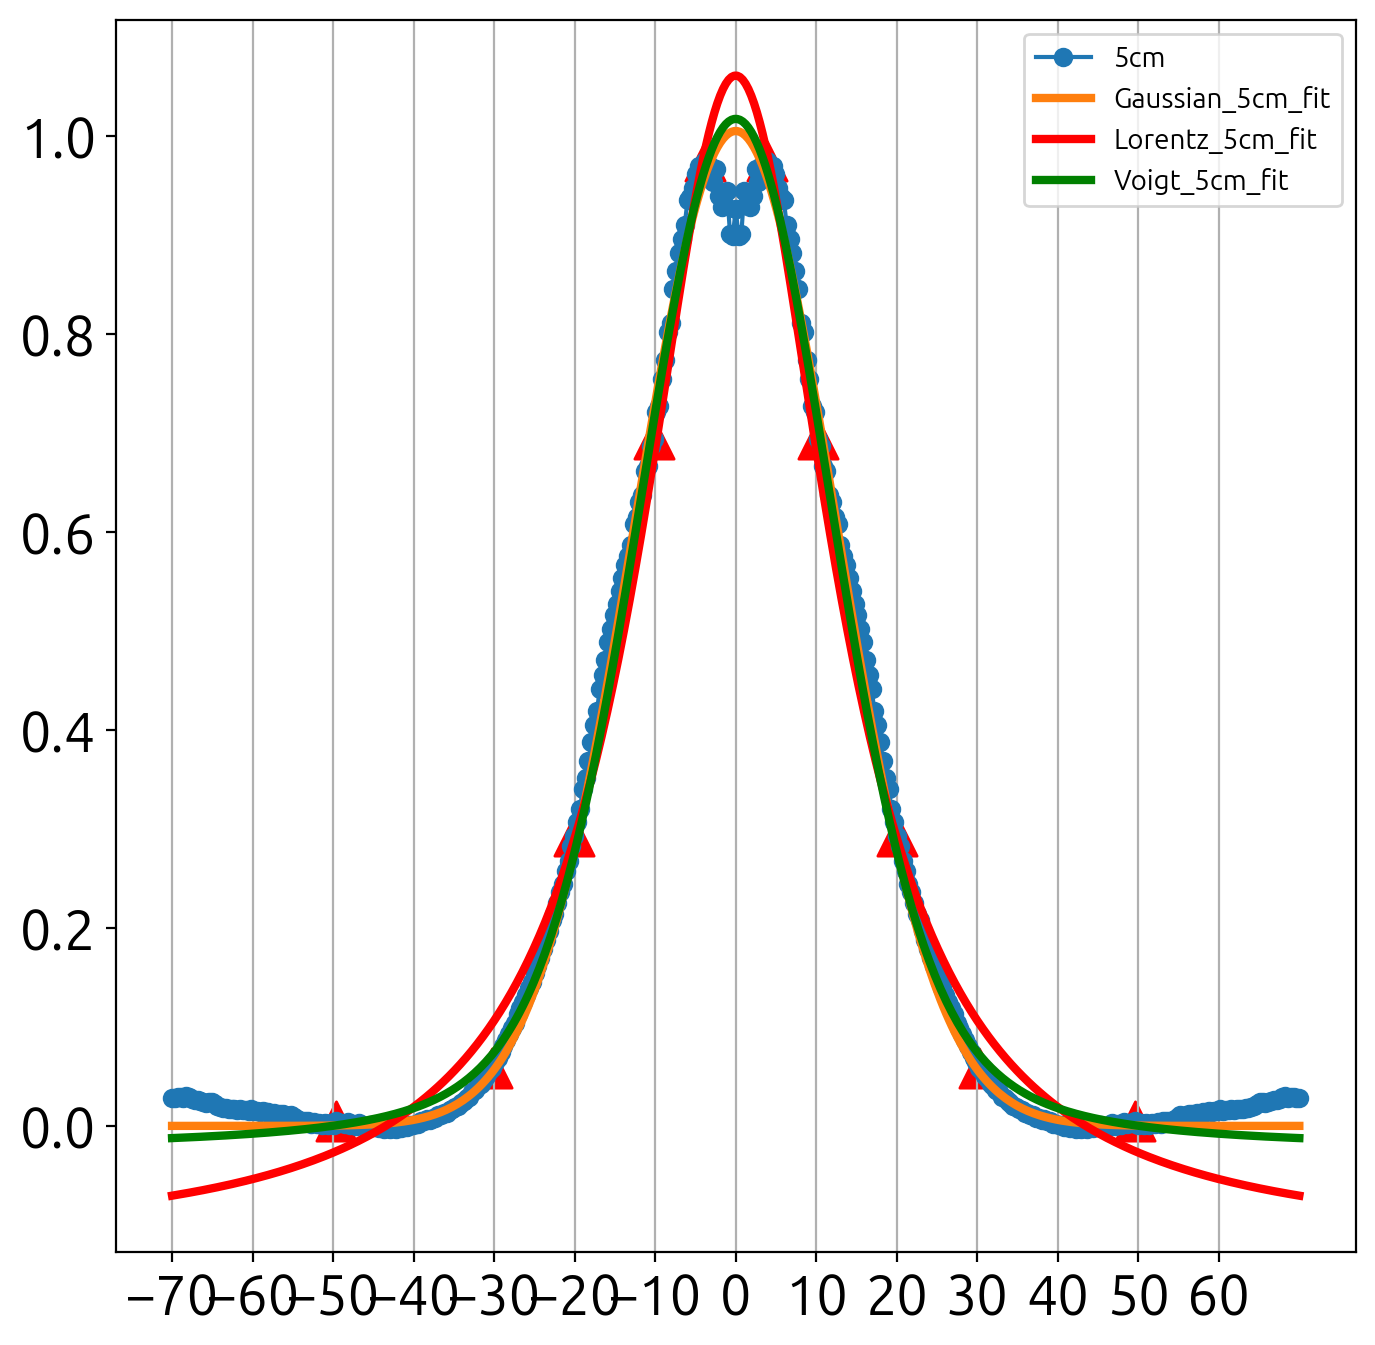

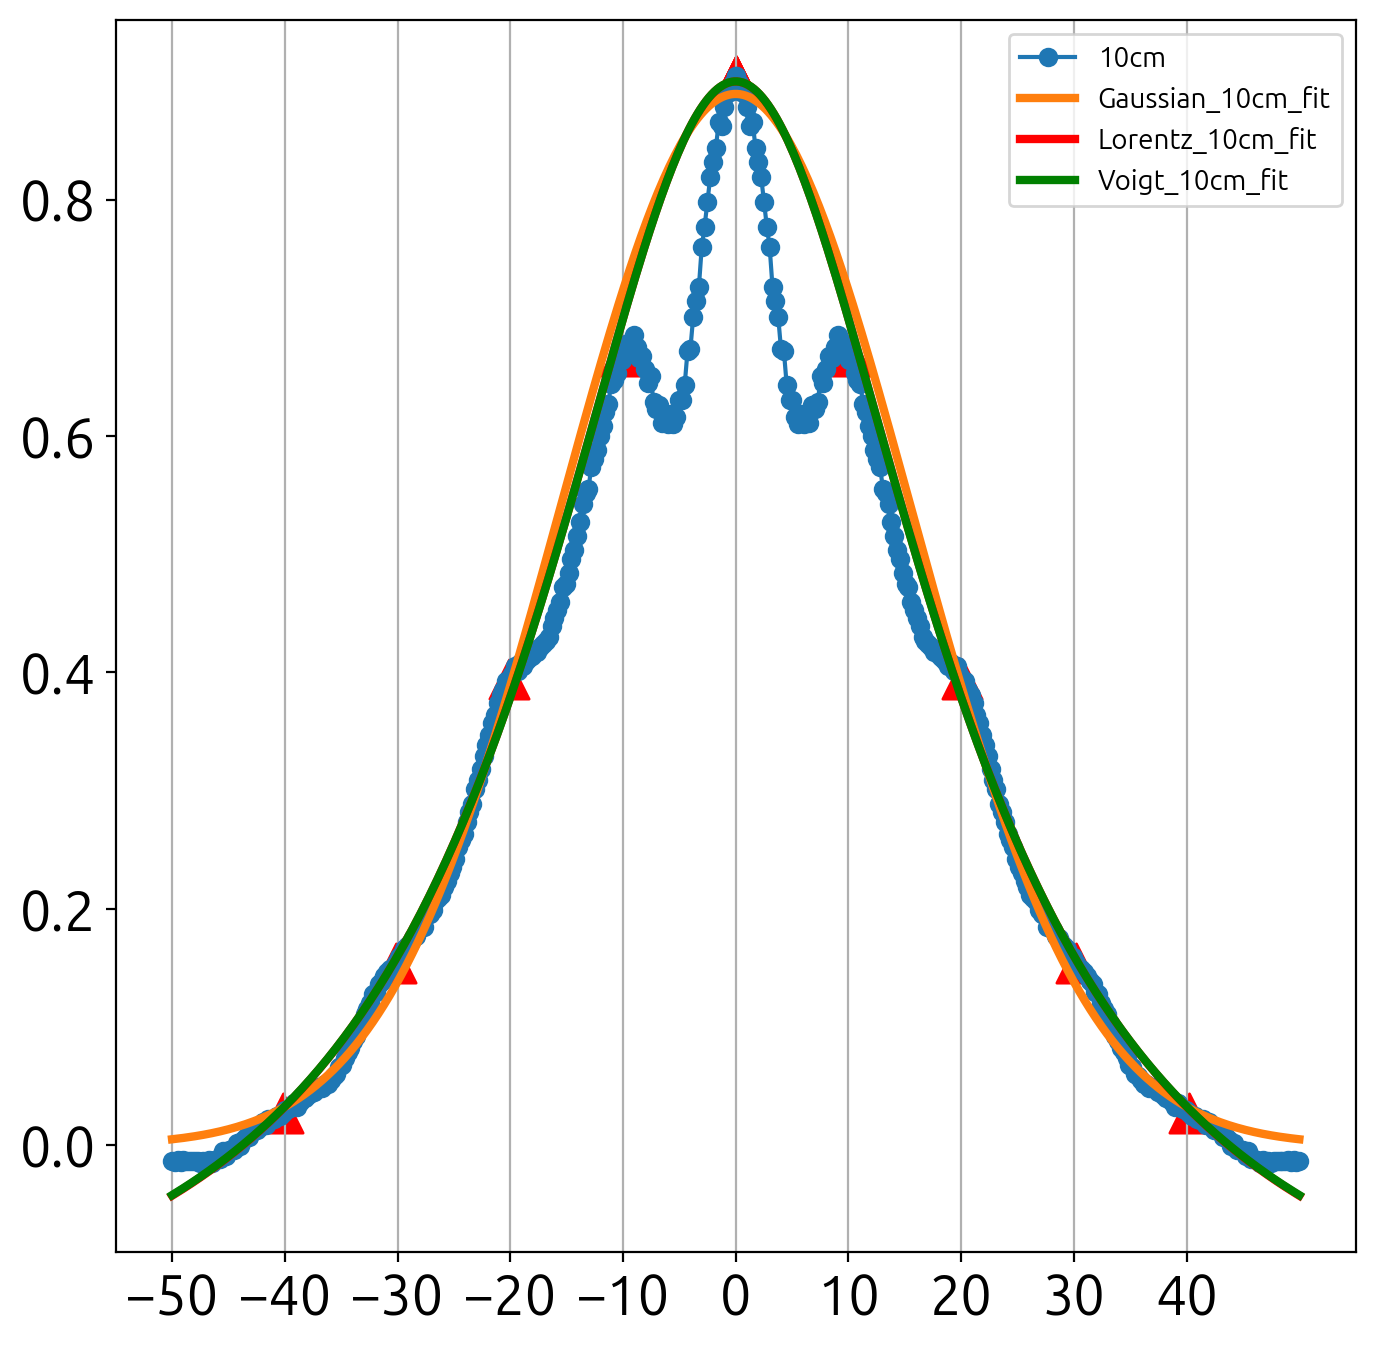

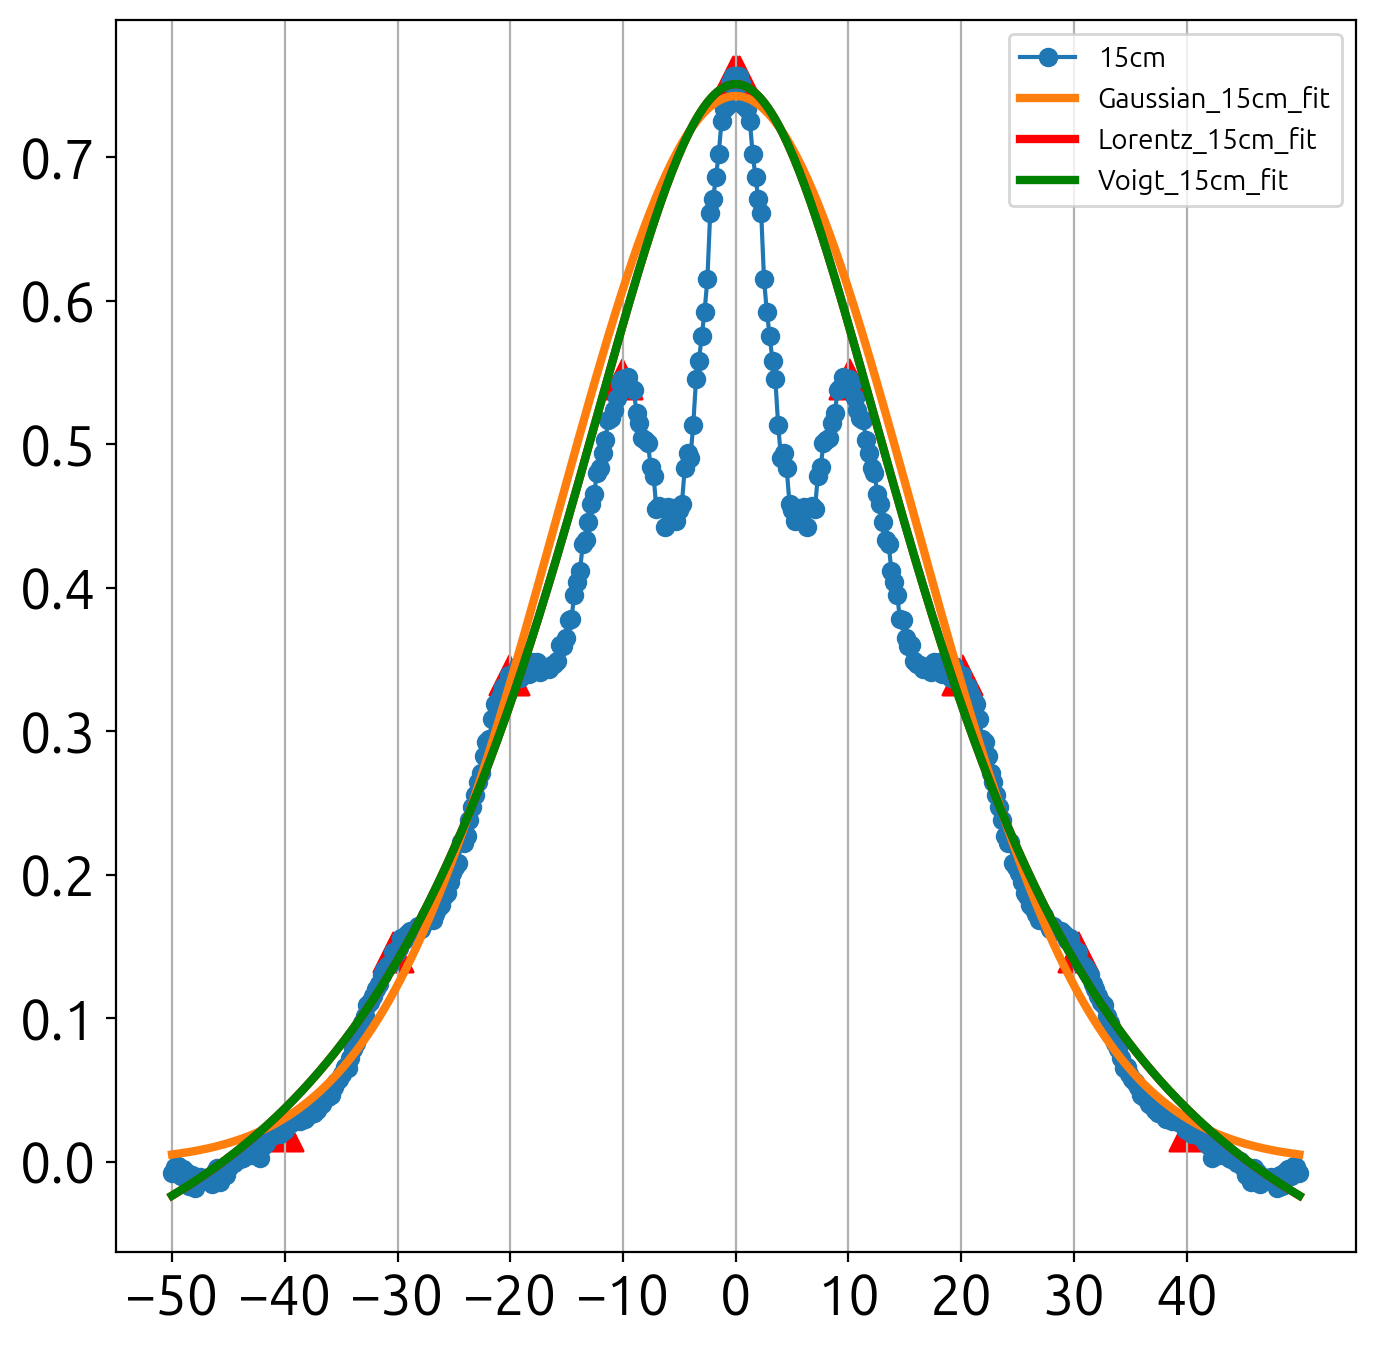

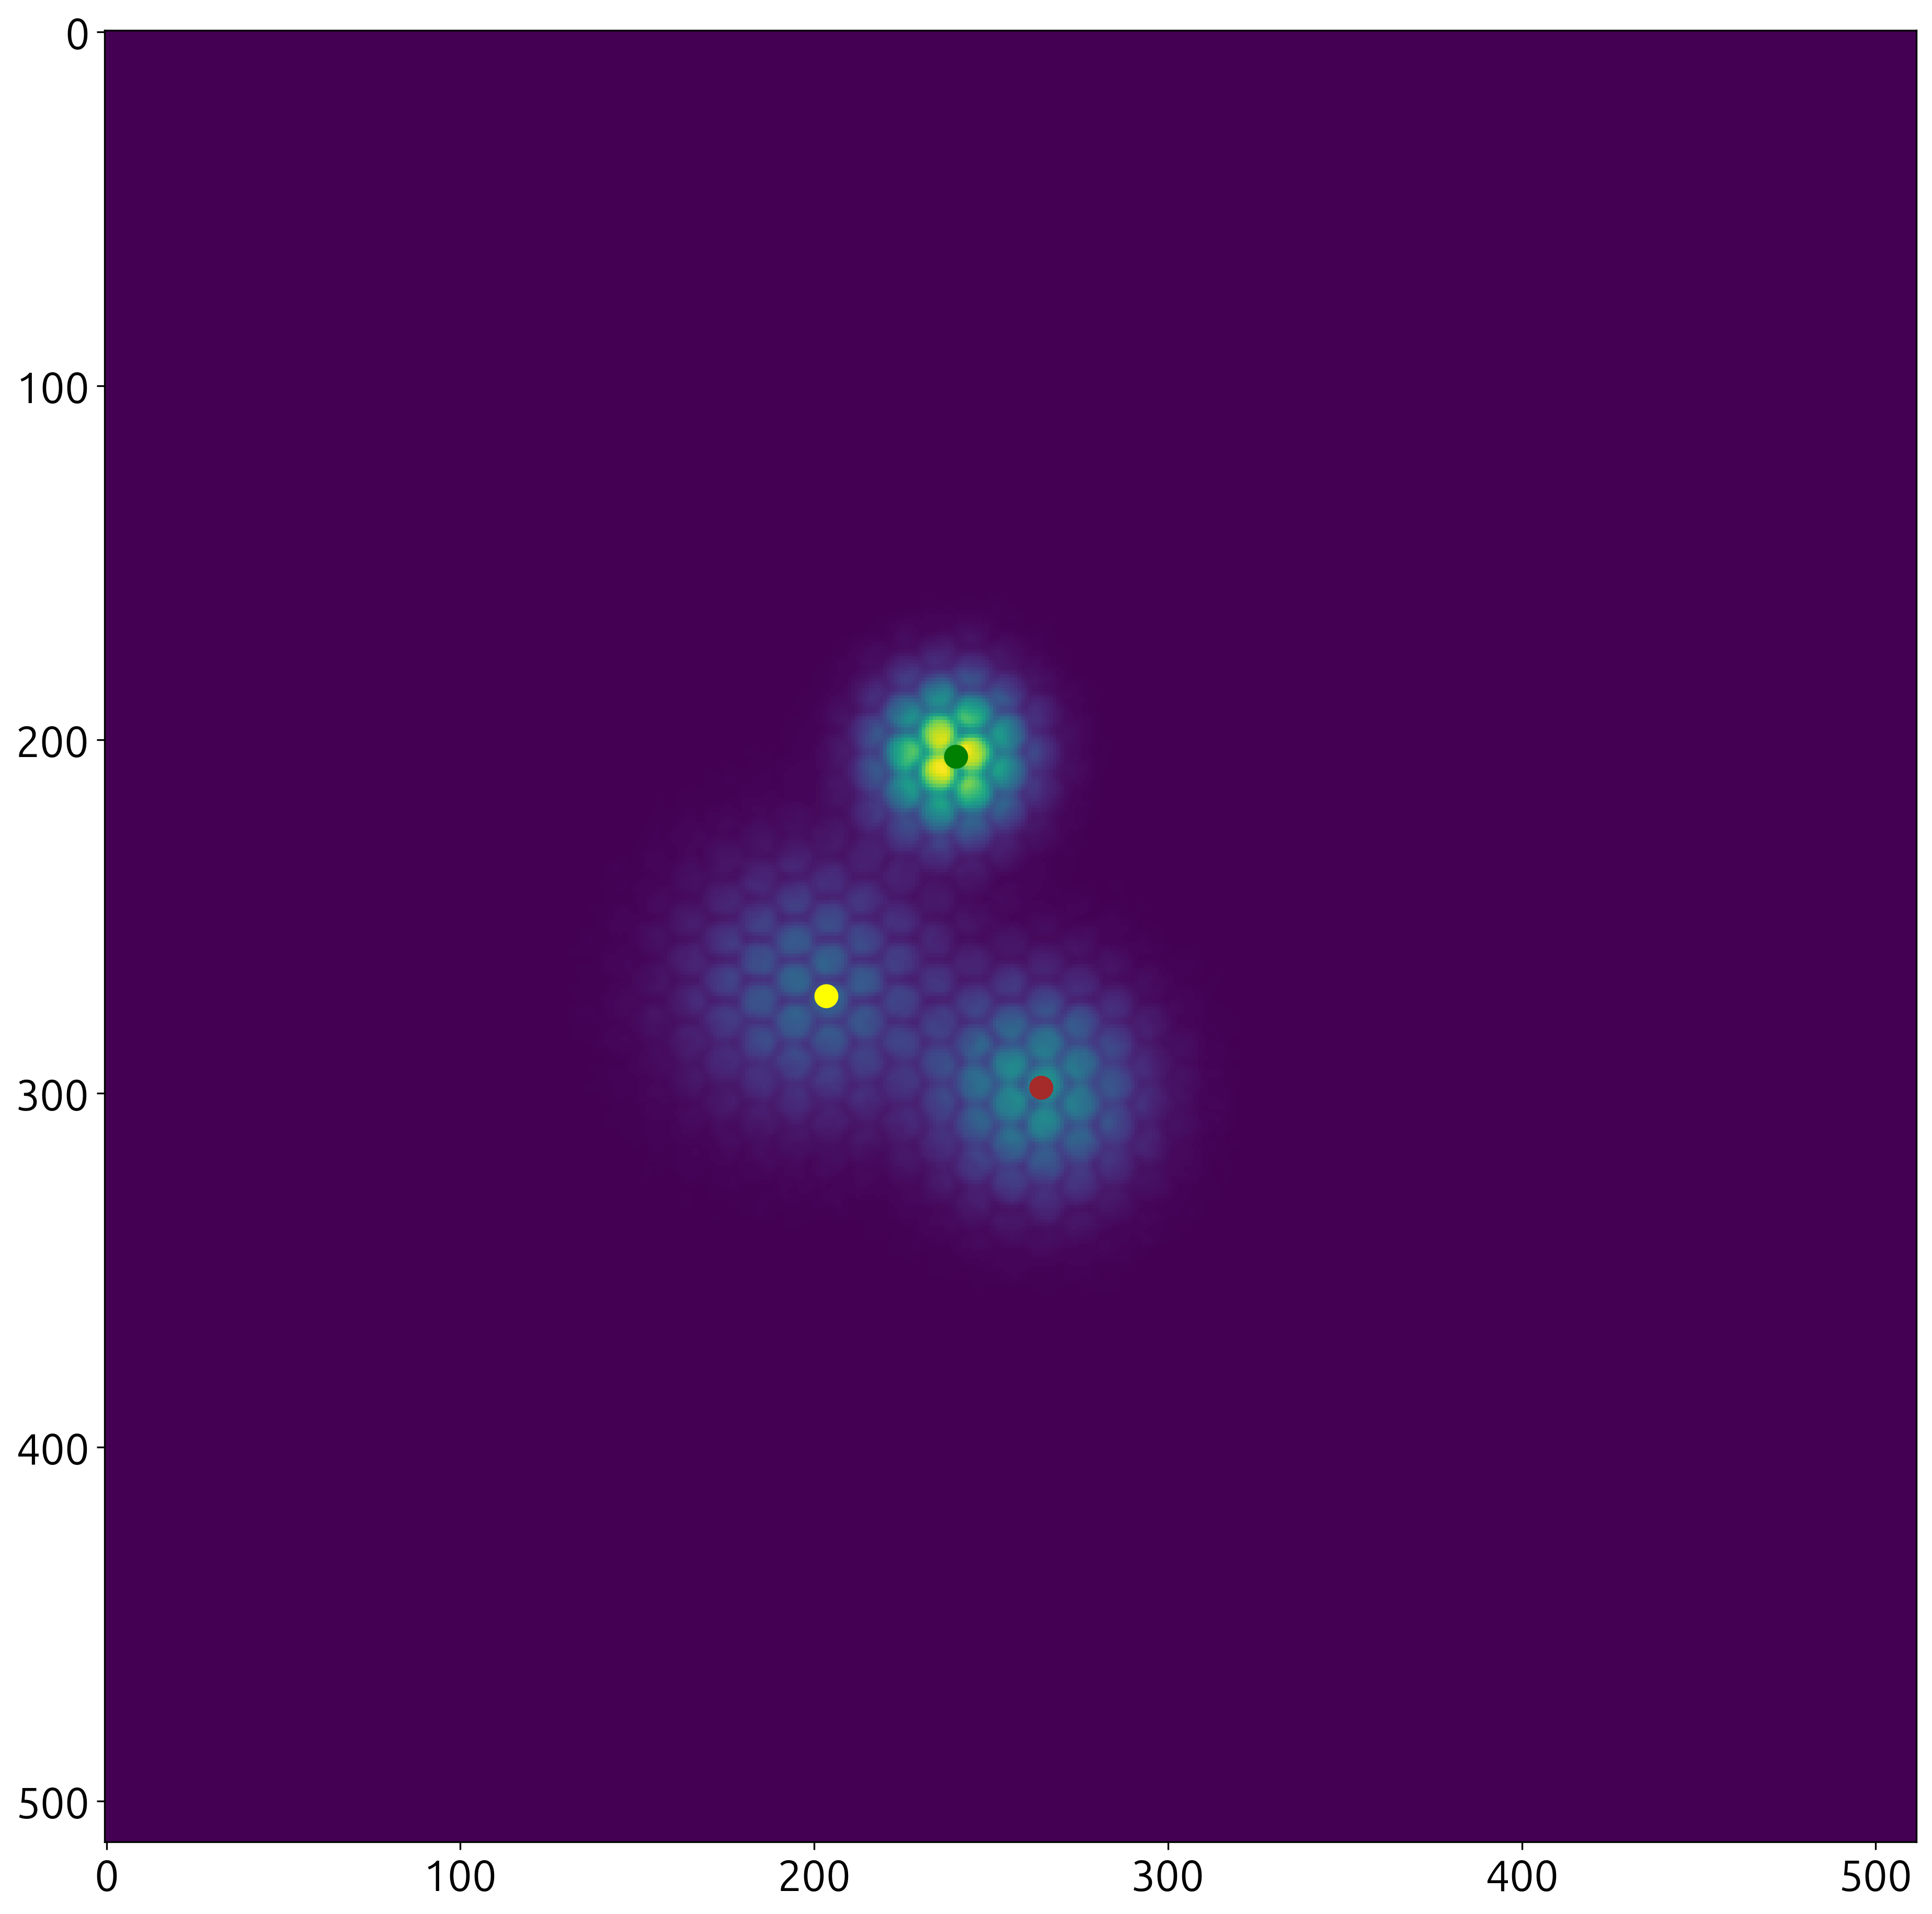

[12.51666284 15.54840576 15.82135069]


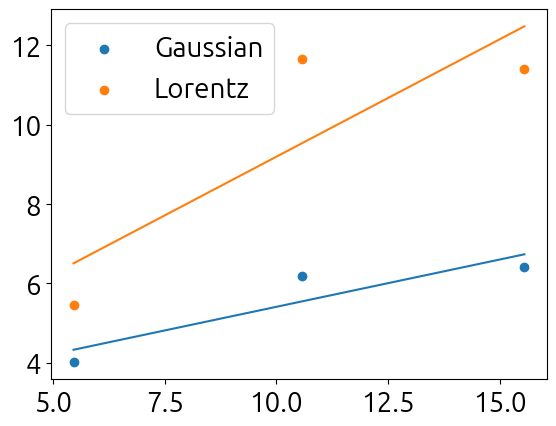

0.769648162542554


In [19]:
Fitv5cm["isPlot"]=Fitv10cm["isPlot"]=Fitv15cm["isPlot"]=[True,False]
Fitv5cm["NumberOfCircles"]=200
Fitv5cm["PeakStep"]=10

Fitv10cm["NumberOfCircles"]=200
Fitv10cm["PeakStep"]=10

Fitv15cm["NumberOfCircles"]=200
Fitv15cm["PeakStep"]=10

Fitv5cm["Radius"]=70
Fitv10cm["Radius"]=50
Fitv15cm["Radius"]=50

Fitv5cm["PeakRegion"]=Fitv10cm["PeakRegion"]=Fitv15cm["PeakRegion"]=[-50,50]
## DC Region
Fitv5cm["DCRegion"]=Fitv10cm["DCRegion"]=Fitv15cm["DCRegion"]=[-50,-40]
Fitv5cm["FitType"]=Fitv10cm["FitType"]=Fitv15cm["FitType"]="All" # Fit Types All or Gaussian,Lorentz,and Voight



theone=image

results={}
## Gaussian or Lorentzian                                 
if(Fitv15cm["FitType"]=="Gaussian" or Fitv15cm["FitType"]=="Lorentz"):
    k=SingleFit(Fitv5cm,Fitv10cm,Fitv15cm,theone,RR=[30,30])[1]
    results["Gaussian"]=k
    
else:
    k=SingleFit(Fitv5cm,Fitv10cm,Fitv15cm,theone,RR=[30,30])[0]
    ## Gaussian
    results["Gaussian"]=np.array([k[0][0][0][2],k[1][0][0][2],k[2][0][0][2]])
    results["Lorentz"]=np.array([k[0][0][1][2],k[1][0][1][2],k[2][0][1][2]])

    
NeedleDistances=np.array([5.46,10.58,15.55])
#NeedleDistances=np.array([4.06,9.18,14.15])
## Get the sigma squared
print(results["Gaussian"])
DD=results["Gaussian"]*pixelSize*Magnefication
slope, intercept = np.polyfit(NeedleDistances, DD**2, 1)
plt.scatter(NeedleDistances,DD**2,label="Gaussian")
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
if("Lorentz" in results):
    DD=results["Lorentz"]*pixelSize*Magnefication
    slope, intercept = np.polyfit(NeedleDistances, DD**2, 1)
    plt.scatter(NeedleDistances,DD**2,label="Lorentz")
    plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
plt.legend()
plt.show()
print(np.sqrt(slope))

In [20]:
PixelShape=theone.shape
CenterPoint=(215,270)
Needle15cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

CenterPoint=(298,297)
Needle10cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

CenterPoint=(261+off[0],180+off[1])
Needle5cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
### Initial values

initialGuess_needle_5cm=np.mean(theone[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],18, Needle5cm_Mask[2][1],18
initialGuess_needle_10cm=np.mean(theone[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 20, Needle10cm_Mask[2][1],20
initialGuess_needle_15cm=np.mean(theone[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 25, Needle15cm_Mask[2][1],25
offset=0.5



In [21]:
def Sumsof3Gaussian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=TwoDGaussian(xy,*fit1)+TwoDGaussian(xy,*fit2)+TwoDGaussian(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Gaussian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt
    

In [22]:
Fit_3Gaussian=FitSumsof3Gaussian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)

[1.65998404e+02 2.39127517e+02 1.35068498e+01 2.05024751e+02
 1.34204603e+01 8.07795507e+01 2.63628152e+02 1.88170864e+01
 2.99496174e+02 1.87917844e+01 5.00714423e+01 1.99972404e+02
 2.29684652e+01 2.71381181e+02 2.31373554e+01 5.24649408e-04]


In [23]:
print(Fit_3Gaussian[3][4])


13.420460337600984


In [24]:
def ConvertToDiffusion(SigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((SigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")

def GetTransVerseDiffusion(Fit,pixelSize,mag):
    DTs=np.array([])
    SigmaXs=np.array([])
    SigmaYs=np.array([])
    positions=[2,7,12]
    
    for i in positions:
        DTX=Fit[3][i]
        DTY=Fit[3][i+2]
        DT=((DTX+DTY)/2)*mag*pixelSize
        
        DTs=np.append(DTs,DT)
        SigmaXs=np.append(SigmaXs,Fit[3][i])
        SigmaYs=np.append(SigmaYs,Fit[3][i+2])
        
    #Error=round(abs(DT-value)/DT,2)
    return DTs,SigmaXs,SigmaYs
    

In [25]:
Diffusion=GetTransVerseDiffusion(Fit_3Gaussian,pixelSize,mag=Magnefication)

In [26]:
print(Diffusion)

(array([2.15418481, 3.00870967, 3.68846564]), array([13.50684977, 18.81708642, 22.96846519]), array([13.42046034, 18.79178443, 23.13735535]))


[[ 0.00024557 -0.00258587]
 [-0.00258587  0.03139636]]
0.9424947119993532 nan
DTs [2.15418481 3.00870967 3.68846564]
Needle Distances [ 5.46 10.58 15.55]
 Diffusion values [0.92190599 0.92499087 0.93536377]


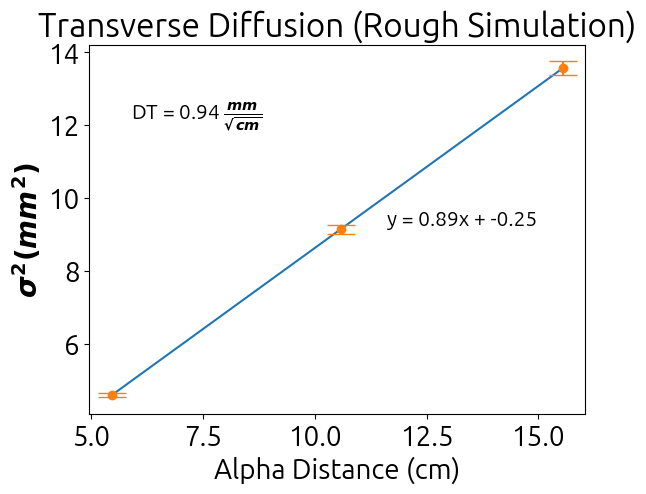

In [27]:
plt.title("Transverse Diffusion (Rough Simulation)")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
#NeedleDistances=np.array([5.46,10.58,15.55])

vv,cov= np.polyfit(NeedleDistances,Diffusion[0]**2,1,cov=True)
slope=vv[0]
intercept=vv[1]
print(cov)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
plt.errorbar(NeedleDistances,(slope*NeedleDistances+intercept),fmt="o-",linestyle="none",capsize=10,yerr=(slope*NeedleDistances+intercept)*np.sqrt(np.sqrt(cov[0][0]))/np.mean((slope*NeedleDistances+intercept)))

DT=np.round(np.sqrt(slope),2)

print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(f"DTs {Diffusion[0]}")
print(f"Needle Distances {NeedleDistances}")
print(f" Diffusion values {Diffusion[0]/np.sqrt(NeedleDistances)}")

13.506849773925294 13.420460337600984
18.81708642306651 18.791784427245048
22.968465189699124 23.13735535229728
Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions
 
Needle Distance is 5.46 cm
DT is 0.92 mm/sqrt(cm) error is 0.0 %
Needle Distance is 10.58 cm
DT is 0.92 mm/sqrt(cm) error is 0.0 %
Needle Distance is 15.55 cm
DT is 0.94 mm/sqrt(cm) error is 2.0 %


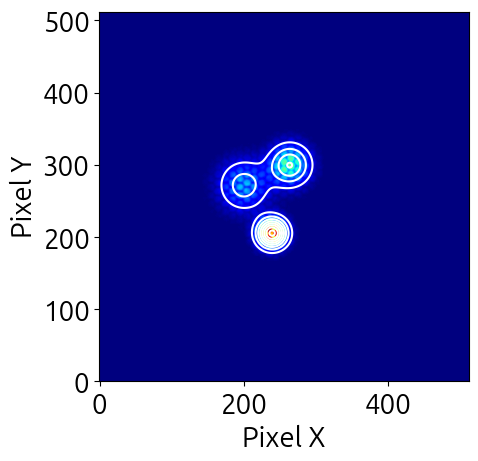

In [28]:

#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(theone),vmax=np.max(theone))
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5])
print(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],NeedleDistances[0],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+5],Fit_3Gaussian[3][4+5],NeedleDistances[1],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Gaussian[3][2+10],Fit_3Gaussian[3][4+10],NeedleDistances[2],pixelSize,Magnefication)



In [29]:
### Lorentzian 

def Lorentzian2D(xy,a,x0,gx,y0,gy):
    x,y=xy
    denominator=np.pi*gx*gy*(1+((x-x0)/gx)**2+((y-y0)/gy)**2)
    result=((a*1)/(denominator))
    return result

def Sumsof3Lorentzian(xy,*initials):
    fit1=initials[0:5]
    fit2=initials[5:10]
    fit3=initials[10:15]
    offset=initials[-1:]
    Sum=Lorentzian2D(xy,*fit1)+Lorentzian2D(xy,*fit2)+Lorentzian2D(xy,*fit3)+offset
    return Sum.ravel()

def FitSumsof3Lorentzian(img,fit1,fit2,fit3,offset,it=15000):
    x = np.linspace(0,img.shape[0],img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=img.ravel()
    popt, pcov = opt.curve_fit(Sumsof3Lorentzian, (xx, yy),flattened , p0=(*fit1,*fit2,*fit3,offset),maxfev=it,method="dogbox")
    print(popt)
    data_fitted = Sumsof3Lorentzian((xx, yy),*popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt  

In [48]:
## This is a test for Lorentzian

PixelShape=theone.shape
CenterPoint=(215,270)
Needle15cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

CenterPoint=(298,297)
Needle10cm_Mask=MaskCreate(PixelShape,50,CenterPoint)

CenterPoint=(261+off[0],180+off[1])
Needle5cm_Mask=MaskCreate(PixelShape,50,CenterPoint)
### Initial values

initialGuess_needle_5cm=np.mean(theone[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0],6, Needle5cm_Mask[2][1],6
initialGuess_needle_10cm=np.mean(theone[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 6, Needle10cm_Mask[2][1],6
initialGuess_needle_15cm=np.mean(theone[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 6, Needle15cm_Mask[2][1],6
offset=0.5



In [49]:
Fit_3Lorentzian=FitSumsof3Lorentzian(theone,initialGuess_needle_5cm,initialGuess_needle_10cm,initialGuess_needle_15cm,offset)

[ 6.72948992e+04  2.38905057e+02 -9.86950466e+00  2.05016743e+02
 -1.02139255e+01  6.29324431e+04  2.62792052e+02 -1.55621651e+01
  2.99979895e+02 -1.28279875e+01  3.97050462e+04  1.98094996e+02
  1.56998314e+01  2.72876311e+02  1.36456990e+01 -1.98888676e+00]


In [50]:
DiffusionLor=GetTransVerseDiffusion(Fit_3Lorentzian,pixelSize,Magnefication)

Magnefication is 10
-9.869504660497471 -10.213925523252216
-15.56216514519172 -12.827987527373725
15.699831370468077 13.645698978672794
Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions
 
Needle Distance is 5.46 cm
DT is -0.69 mm/sqrt(cm) error is 175.0 %
Needle Distance is 10.58 cm
DT is -0.7 mm/sqrt(cm) error is 176.0 %
Needle Distance is 15.55 cm
DT is 0.6 mm/sqrt(cm) error is 35.0 %


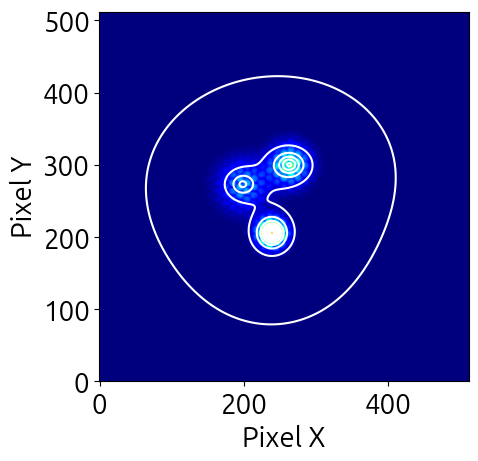

In [51]:
print(f"Magnefication is {Magnefication}")
#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Lorentzian[0], cmap=plt.cm.jet, origin='lower',vmin=np.mean(Fit_3Lorentzian[0]),vmax=np.max(Fit_3Lorentzian[0]))
plt.contour(Fit_3Lorentzian[2][0], Fit_3Lorentzian[2][1], Fit_3Lorentzian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Lorentzian[3][2],Fit_3Lorentzian[3][4])
print(Fit_3Lorentzian[3][2+5],Fit_3Lorentzian[3][4+5])
print(Fit_3Lorentzian[3][2+10],Fit_3Lorentzian[3][4+10])


#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Lorentzian[3][2],Fit_3Lorentzian[3][4],NeedleDistances[0],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Lorentzian[3][2+5],Fit_3Lorentzian[3][4+5],NeedleDistances[1],pixelSize,Magnefication)
ConvertToDiffusion(Fit_3Lorentzian[3][2+10],Fit_3Lorentzian[3][4+10],NeedleDistances[2],pixelSize,Magnefication)


[[ 0.01556375 -0.1638863 ]
 [-0.1638863   1.98982823]]
0.5398698934962973 1.1610378832858446
DTs [-1.60667441 -2.27121221  2.34764243]
Needle Distances [ 5.46 10.58 15.55]
 Diffusion values [-0.68759317 -0.69825633  0.59534232]


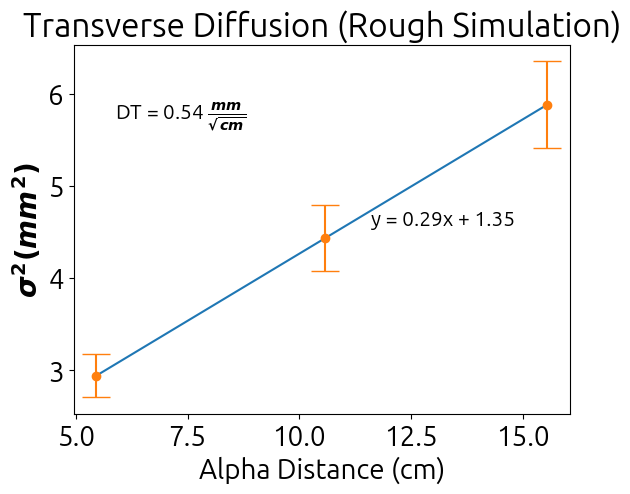

In [52]:
plt.title("Transverse Diffusion (Rough Simulation)")
plt.xlabel("Alpha Distance (cm)")
plt.ylabel(r'$\sigma^2 (mm^2)$')
#NeedleDistances=np.array([5.46,10.58,15.55])

vv,cov= np.polyfit(NeedleDistances,DiffusionLor[0]**2,1,cov=True)
slope=vv[0]
intercept=vv[1]
print(cov)
plt.plot(NeedleDistances,(slope*NeedleDistances+intercept))
plt.errorbar(NeedleDistances,(slope*NeedleDistances+intercept),fmt="o-",linestyle="none",capsize=10,yerr=(slope*NeedleDistances+intercept)*np.sqrt(np.sqrt(cov[0][0]))/np.mean((slope*NeedleDistances+intercept)))

DT=np.round(np.sqrt(slope),2)

print(np.sqrt(slope),np.sqrt(intercept))

plt.text(0.35,0.85,f"DT = {DT} " + r"$\frac{mm}{\sqrt{cm}}$",fontsize=15,horizontalalignment='right',verticalalignment='top',transform = plt.gca().transAxes)
#plt.text(5.8, 14, f"DT={D}" + r"$\frac{mm}{\sqrt{cm}}$", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.6, 0.5,f"y = {round(slope,2)}x + {round(intercept,2)} ",fontsize=15,horizontalalignment='left',verticalalignment='bottom',transform = plt.gca().transAxes)
print(f"DTs {DiffusionLor[0]}")
print(f"Needle Distances {NeedleDistances}")
print(f" Diffusion values {DiffusionLor[0]/np.sqrt(NeedleDistances)}")